In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import joblib

print("Loading Competitive Procurements Data...")
df = pd.read_csv('/kaggle/input/prozorro-public-procurement-dataset/Competitive_procurements.csv', 
                 usecols=['lot_id', 'participant_code', 'participant_name', 'supplier_dummy'])

df['lot_id'] = df['lot_id'].astype(str)
df['participant_code'] = df['participant_code'].astype(str)

name_lookup = df.set_index('participant_code')['participant_name'].to_dict()

bid_counts = df['lot_id'].value_counts()
competitive_lots = bid_counts[bid_counts > 1].index
df_clean = df[df['lot_id'].isin(competitive_lots)]

print(f" Loaded {len(df_clean)} bids from competitive tenders.")

Loading Competitive Procurements Data...
 Loaded 2014658 bids from competitive tenders.


Processor A: Building Collusion Network...
 Collusion Graph Built: 184985 suspicious links found.


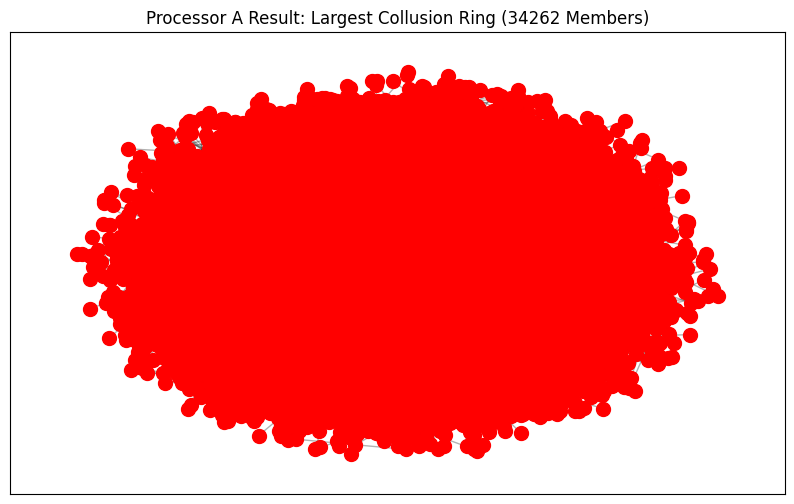

In [2]:
lot_groups = df_clean.groupby('lot_id')['participant_code'].apply(list)

print("Processor A: Building Collusion Network...")

pair_counts = {}
for bidders in lot_groups:
    unique_bidders = sorted(list(set(bidders)))
    for pair in itertools.combinations(unique_bidders, 2):
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

G = nx.Graph()
THRESHOLD = 3  

for pair, count in pair_counts.items():
    if count >= THRESHOLD:
        G.add_edge(pair[0], pair[1], weight=count)

print(f" Collusion Graph Built: {G.number_of_edges()} suspicious links found.")

cartels = list(nx.connected_components(G))
large_cartels = [c for c in cartels if len(c) >= 3]

if len(large_cartels) > 0:
    largest_group = max(large_cartels, key=len)
    subgraph = G.subgraph(largest_group)
    
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph, k=0.15)
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='red')
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
    plt.title(f"Processor A Result: Largest Collusion Ring ({len(largest_group)} Members)")
    plt.show()

Processor B: Calculating Bid Volumes...
 Volume Data added to Graph.


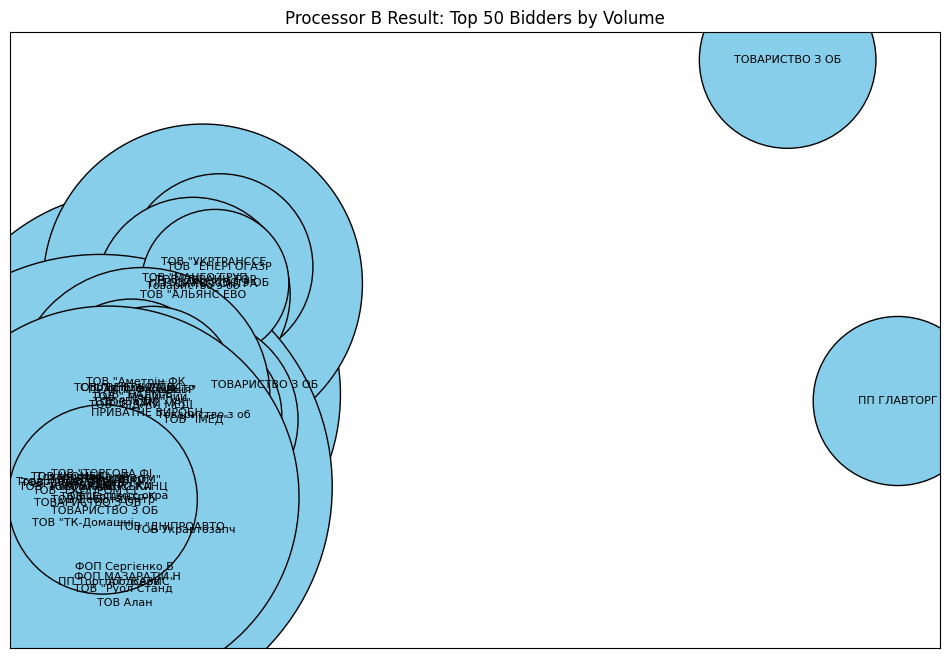

In [4]:
print("Processor B: Calculating Bid Volumes...")

real_bid_counts = df_clean['participant_code'].value_counts().to_dict()

for node in G.nodes:
    G.nodes[node]['bid_count'] = real_bid_counts.get(node, 1)

print(" Volume Data added to Graph.")

top_bidders = sorted(G.nodes, key=lambda x: G.nodes[x]['bid_count'], reverse=True)[:50]
subgraph_vol = G.subgraph(top_bidders)

plt.figure(figsize=(12, 8))
pos_vol = nx.spring_layout(subgraph_vol, k=0.4, seed=42)
sizes = [subgraph_vol.nodes[n]['bid_count'] * 5 for n in subgraph_vol.nodes]

nx.draw_networkx_nodes(subgraph_vol, pos_vol, node_size=sizes, node_color='skyblue', edgecolors='black')
nx.draw_networkx_edges(subgraph_vol, pos_vol, alpha=0.2)

# Label the big ones
labels = {n: name_lookup.get(n, n)[:15] for n in subgraph_vol.nodes}
nx.draw_networkx_labels(subgraph_vol, pos_vol, labels=labels, font_size=8)

plt.title("Processor B Result: Top 50 Bidders by Volume")
plt.show()

Generating Bar Graph for Top Bidders...


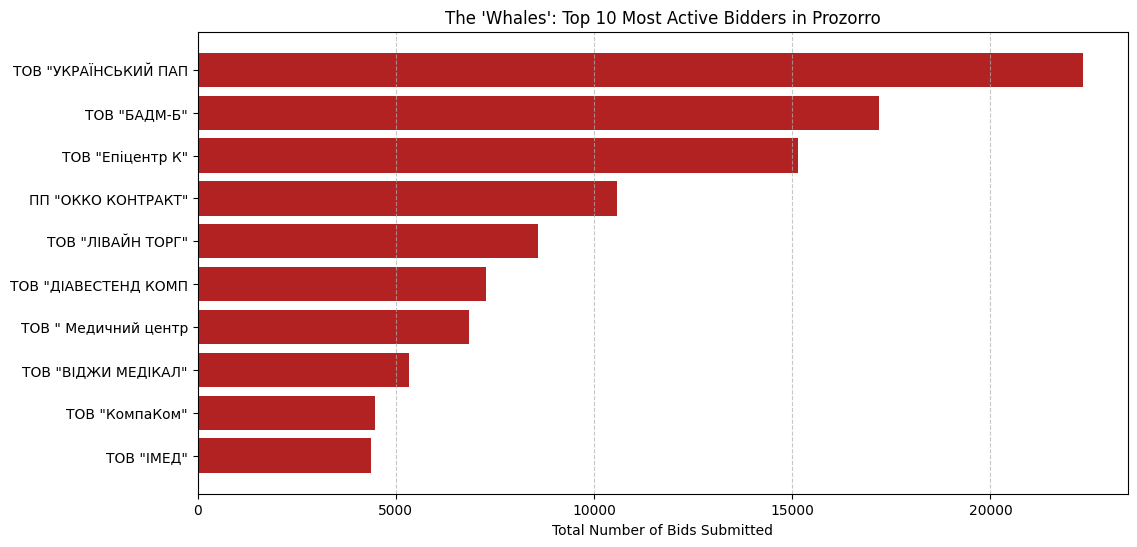

In [5]:

print("Generating Bar Graph for Top Bidders...")

sorted_bidders = sorted(real_bid_counts.items(), key=lambda x: x[1], reverse=True)[:10]

ids = [x[0] for x in sorted_bidders]
counts = [x[1] for x in sorted_bidders]

names = [name_lookup.get(uid, uid)[:20] for uid in ids] # Limit name to 20 chars

plt.figure(figsize=(12, 6))
plt.barh(names, counts, color='firebrick') 

plt.xlabel("Total Number of Bids Submitted")
plt.title("The 'Whales': Top 10 Most Active Bidders in Prozorro")
plt.gca().invert_yaxis() # Put the #1 bidder at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [6]:
joblib.dump(G, 'bid_rigging_graph.pkl')

joblib.dump(name_lookup, 'vendor_names.pkl')

print(" FINAL SUCCESS!")
print("The 'bid_rigging_graph.pkl' now contains both Collusion Logic and Volume Logic.")

 FINAL SUCCESS!
The 'bid_rigging_graph.pkl' now contains both Collusion Logic and Volume Logic.
